# Singular Value Decomposition of the snapshots

This notebook can be executed only using the raw simulation data from OpenFOAM, mapped into FEniCSx. It is stored in the repository for completeness.

At first, let us define the mesh onto which the snapshots are defined

In [8]:
from mesh import *

domain, ct, ft = evol_mesh()

Info    : Reading '../EVOL_geom.geo'...
Info    : Done reading '../EVOL_geom.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : [ 90%] Meshing curve 12 (Line)
Info    : [100%] Meshing curve 13 (Line)
Info    : Done meshing 1D (Wall 0.000855s, CPU 0.001012s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.55474s, CPU 0.544249s)
Info    : 45730 nodes 92052 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wa

Let us load some features of the dataset: the fields imported, a logic variable to establish if it is a vector field or scalar and the time instants

In [9]:
import pickle
import numpy as np

var_names, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))

print(var_names)

['flux1', 'flux2', 'flux3', 'flux4', 'flux5', 'flux6', 'prec1', 'prec2', 'prec3', 'prec4', 'prec5', 'prec6', 'prec7', 'prec8', 'dec1', 'dec2', 'dec3', 'T', 'p', 'U']


The OpenFOAM simulation was performed on a mesh of $\mathcal{N}_h=94611$ elements (2D axial-symmetric). Since the size of the raw data is large ($\sim$ 10 GB), a compressed dataset has been uploaded on [Zenodo](https://zenodo.org/records/15015236) using the Singular Value Decomposition with rank $r=50$.

Before executing this cell, be sure to download the dataset from the link above and place in the main directory of the repository (or modify the `path_snaps` variable). The snapshot matrix $\mathbb{X}^\psi\in\mathbb{R}^{\mathcal{N}_h\times N_t}$ for the generic field $\psi$ is obtained by multiplying the SVD matrices $\mathbb{U}^\psi\in\mathbb{R}^{\mathcal{N}_h\times r}$ and $\mathbb{\Sigma}^\psi\in\mathbb{R}^{r\times r}$ and $V_h^{\psi}\in\mathbb{R}^{r\times N_t}$
\begin{equation*}
\mathbb{X}^{\psi} = \mathbb{U}^\psi \mathbb{\Sigma}^\psi V_h^{\psi}
\end{equation*}

The compressed data were also rescaled to have unit mean, thus the reconstructued dataset will be
\begin{equation*}
\mathbb{X}^{\psi} \leftarrow \mathbb{X}^{\psi} \cdot \langle \mathbb{X}_0^{\psi} \rangle
\end{equation*}
where $\langle \mathbb{X}_0^{\psi} \rangle$ is the mean of the original dataset at the critical condition ($t=0$).

In [10]:
path_snaps = '../../NuSHRED_Datasets/D1/CompressedDataset/'

snaps = dict()

# Load the dataset, compressed with SVD
u_data = pickle.load(open(path_snaps+'u_total.svd', 'rb')) # shape Nh x rank
s_data = pickle.load(open(path_snaps+'s_total.svd', 'rb')) # shape rank
v_data = pickle.load(open(path_snaps+'v_total.svd', 'rb')) # shape len(var_names) * rank x Nt

scaler_data = pickle.load(open(path_snaps+'rescaling.svd', 'rb')) # shape len(var_names)

rank = u_data[var_names[0]].shape[1]
print('Rank of the compressed dataset: ', rank)

for field_i, field in enumerate(var_names):
    idx_rec = np.arange(field_i*rank, (field_i+1)*rank)
    snaps[field] = np.linalg.multi_dot([u_data[field], np.diag(s_data[field]), v_data[idx_rec]]) * scaler_data[field_i]

Rank of the compressed dataset:  50


## Randomized SVD
On the reconstructed dataset, we can perform a randomized SVD to obtain the reduced basis $\mathbb{U}_r^\psi$, the singular values $\Sigma_r$ and the reduced coefficients $V_h^\psi$ with rank $r$ for generic field $\psi$.

**Note:** be aware that in this case you could also choose to keep only the first $r$ singular values and vectors of the SVD of the original compressed dataset.

In [11]:
from sklearn.utils.extmath import randomized_svd
import numpy as np

rescaling_snaps = list()
new_var_names = list()
Nmodes = []

u_total = dict()
s_total = dict()

for field_i, field in enumerate(var_names):
    
    print(field)
    u = snaps[field]
    rescaling_snaps.append(np.mean(u[:,0]))

    X = u / rescaling_snaps[field_i]
        
    if field_i + 1 == len(var_names): # velocity
        _Nmodes = 10
    else:
        _Nmodes = 10
    
    Nmodes.append(_Nmodes)
    
    u_svd, s_svd, v_svd = randomized_svd(X, n_components = _Nmodes, n_iter = 'auto')

    if field_i == 0:
        v_total = v_svd
    else:
        v_total = np.vstack((v_total, v_svd))
        
    s_total[field] = s_svd.flatten()
    u_total[field] = u_svd
        
    new_var_names.append(field)
        
rescaling_snaps = np.asarray(rescaling_snaps)

flux1
flux2
flux3
flux4
flux5
flux6
prec1
prec2
prec3
prec4
prec5
prec6
prec7
prec8
dec1
dec2
dec3
T
p
U


Let us compute the maximum training error

In [5]:
for field_i in range(len(var_names)):
    field = var_names[field_i]

    rec = rescaling_snaps[field_i] * (u_total[field] @ (np.diag(s_total[field]) @ v_total[_Nmodes * field_i: _Nmodes * (field_i + 1)]))

    errors = np.linalg.norm(rec - snaps[field], axis = 0) / np.linalg.norm(snaps[field], axis=0)

    print(field)
    print('   max = {:.3e}'.format(np.max(errors)) +' and ave {:.3e}'.format(np.mean(errors)))

flux1
   max = 1.025e-04 and ave 4.623e-05
flux2
   max = 1.043e-04 and ave 4.699e-05
flux3
   max = 1.052e-04 and ave 4.725e-05
flux4
   max = 1.013e-04 and ave 4.490e-05
flux5
   max = 1.022e-04 and ave 4.571e-05
flux6
   max = 1.535e-04 and ave 7.641e-05
prec1
   max = 7.571e-04 and ave 3.760e-04
prec2
   max = 1.234e-03 and ave 5.993e-04
prec3
   max = 1.717e-03 and ave 8.379e-04
prec4
   max = 4.158e-03 and ave 1.967e-03
prec5
   max = 6.108e-03 and ave 2.798e-03
prec6
   max = 6.108e-03 and ave 2.798e-03
prec7
   max = 4.303e-03 and ave 1.968e-03
prec8
   max = 2.675e-03 and ave 1.319e-03
dec1
   max = 6.454e-04 and ave 3.139e-04
dec2
   max = 9.284e-04 and ave 4.687e-04
dec3
   max = 5.564e-03 and ave 2.609e-03
T
   max = 3.018e-03 and ave 1.224e-03
p
   max = 4.481e-04 and ave 8.716e-05
U
   max = 2.163e-02 and ave 1.195e-02


Let us plot the singular values

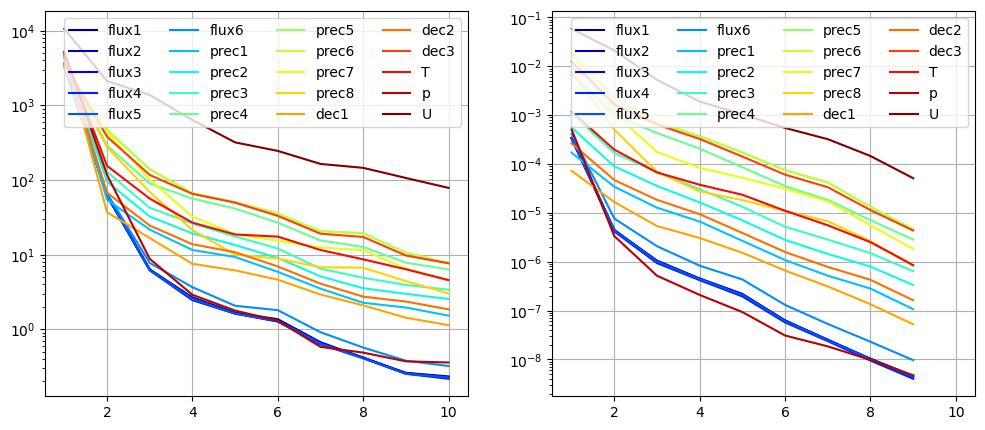

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].semilogy(N_plot, s_total[field], color=colors[field_i], label=field)
    axs[1].semilogy(N_plot[:-1], 1-np.cumsum(s_total[field]**2)[:-1] / np.sum(s_total[field]**2), color=colors[field_i], label=field)

for ax in axs:
    ax.legend(ncols = 4)
    ax.grid()

Let us upscale the time series to 2000 points and store all the results in `OfflineSVD`

In [7]:
from scipy.interpolate import CubicSpline
import os

path='./OfflineSVD/'
if not os.path.exists(path):
    os.makedirs(path)
    
[r,nt] = v_total.shape
t = np.asarray(times)
# newnt = 500

# new_t = np.linspace(t[0], t[-1], newnt)
# v_total_new = np.zeros((r,newnt))

# for j in range(r):
#     spline = CubicSpline(t, v_total[j,:])
#     v_total_new[j,:] = spline(new_t)

pickle.dump(u_total, open(path+"u_total.svd", 'wb'))
# pickle.dump(v_total_new, open(path+"v_total.svd", 'wb'))
pickle.dump(v_total, open(path+"v_total.svd", 'wb'))
pickle.dump(s_total, open(path+"s_total.svd", 'wb'))
pickle.dump(new_var_names, open(path+"var.names", 'wb'))

pickle.dump(rescaling_snaps, open(path+"rescaling.svd", 'wb'))
pickle.dump(Nmodes, open(path+"Nmodes.svd", 'wb'))